## Part 1: Environment Setup & Library Imports

### Description
In this initial phase, we import the essential libraries required for building, training, and evaluating deep learning models, as well as handling data and visualizing results.

The following core libraries are utilized:

- **TensorFlow & Keras** for designing and training the neural network  
- **NumPy** for efficient numerical and array-based computations  
- **Matplotlib & Seaborn** for data and performance visualization  
- **Scikit-learn (metrics)** for generating detailed evaluation reports, including accuracy, precision, recall, F1-score, and confusion matrices  

This setup ensures a clean, reproducible environment and provides all necessary tools for model development, analysis, and evaluation.

### Key Components
- Deep learning framework initialization  
- Numerical computation support  
- Visualization tools for training and evaluation metrics  
- Comprehensive model performance reporting


In [2]:
import os
import random
from PIL import Image
import tarfile
import httpx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Part 2: Data Acquisition & Automated Extraction

### Overview
This section handles the **automated ingestion of the dataset** from a remote cloud storage source and prepares it for downstream computer vision tasks.

A fully **asynchronous pipeline** is implemented to efficiently download and extract the dataset while minimizing execution blocking and improving reliability.

---

### Configuration
- A remote **cloud-hosted URL** is defined, pointing to a compressed `.tar` archive containing the satellite imagery.
- A local extraction directory (`./data`) is created dynamically if it does not already exist, ensuring a clean and reproducible workspace.

---

### Asynchronous Data Download
To improve performance and robustness, the dataset is downloaded using an **asynchronous HTTP client**:

- The `httpx.AsyncClient` library is used to fetch the dataset without blocking the execution flow.
- The dataset is downloaded only if it does not already exist locally, preventing redundant network calls.
- Redirects are handled automatically to ensure reliable data retrieval.

This approach is especially beneficial in cloud-based environments such as Kaggle notebooks.

---

### Safe and Controlled Extraction
Once the archive is downloaded:

- The dataset is extracted using Python’s built-in `tarfile` module.
- Files are safely unpacked into the designated directory (`./data`).
- The resulting folder structure is automatically aligned with directory-based image loaders.

This guarantees compatibility with Keras utilities such as:
- `ImageDataGenerator`
- `image_dataset_from_directory`

---

### Outcome
After successful execution of this step:
- The dataset is fully available locally  
- The directory structure is correctly prepared  
- The environment is ready for preprocessing, augmentation, and model training  

This automated pipeline ensures **reproducibility**, **efficiency**, and **scalability** for deep learning experimentation.


In [3]:
# Configuration of URL and Directories
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"
extract_dir = "./data"
os.makedirs(extract_dir, exist_ok=True)

# Asynchronous function to handle data ingestion
async def download_and_extract(url, extract_path):
    tar_path = os.path.join(extract_path, "dataset.tar")
    if not os.path.exists(tar_path):
        print("Downloading dataset...")
        async with httpx.AsyncClient() as client:
            response = await client.get(url, follow_redirects=True)
            with open(tar_path, "wb") as f:
                f.write(response.content)
    
    print("Extracting files...")
    with tarfile.open(tar_path, 'r:*') as tar:
        tar.extractall(path=extract_path)
    print("Environment Ready.")


In [4]:
await download_and_extract(url, extract_dir)

Extracting files...


/tmp/ipykernel_55/858638652.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Environment Ready.


## Part 3: Dataset Overview & Structure

### Dataset Description
This dataset consists of high-resolution **satellite images** collected for a **binary land-use classification task**.  
The primary objective is to distinguish between **agricultural** and **non-agricultural** areas based on visual patterns extracted from satellite imagery.

### Class Definitions
The dataset is divided into two main categories:

- **Agricultural Land**  
  Images representing crop fields, farming regions, and cultivated land areas.

- **Non-Agricultural Land**  
  Images representing urban zones, water bodies, forests, and other non-farming environments.

---

### Dataset Structure
After extracting the compressed `.tar` archive, the dataset follows a clean and scalable directory-based structure:



In [5]:

def display_and_save_samples(data_dir, num_samples=4, save_dir="./samples"):
    """
    Display a few sample images from each class and save them to a folder.

    Args:
    - data_dir: path to the dataset folder containing subfolders per class
    - num_samples: number of images to show per class
    - save_dir: folder to save the sample images
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Get class folders
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    plt.figure(figsize=(12, 3))
    count = 1
    
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        images = os.listdir(cls_dir)
        sample_imgs = random.sample(images, min(num_samples, len(images)))
        
        for img_name in sample_imgs:
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)
            
            # Display
            plt.subplot(len(classes), num_samples, count)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
            
            # Save the image
            img_save_path = os.path.join(save_dir, f"{cls}_{img_name}")
            img.save(img_save_path)
            
            count += 1
    
    plt.tight_layout()
    plt.show()
    print(f"Sample images saved to: {save_dir}")




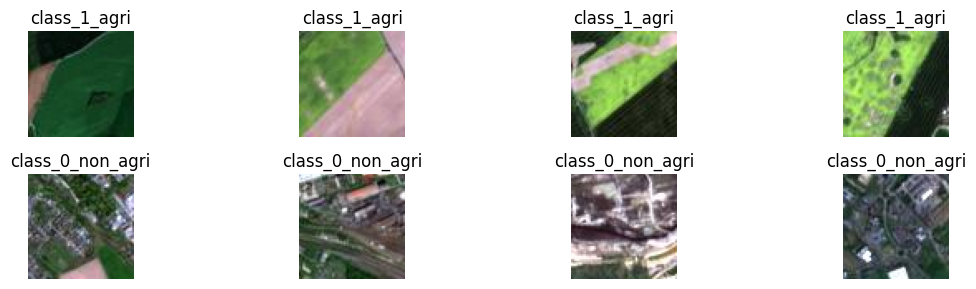

Sample images saved to: ./samples


In [6]:
# -------------------------------
# Example usage (after dataset extraction)
# -------------------------------
dataset_path = "./data/images_dataSAT"
display_and_save_samples(dataset_path, num_samples=4)

#### Part 4: Data Preprocessing & Augmentation

### Description
To make the model more robust and generalizable, we apply **data augmentation** techniques to the training images.  
This involves performing **random transformations** that expand the diversity of the dataset and prevent **overfitting**, which is especially important when working with satellite imagery.

### Key Transformations
- **Rescaling:** Normalize pixel values to the range [0,1]  
- **Random Rotations:** Rotate images up to 40 degrees  
- **Width and Height Shifts:** Random horizontal and vertical translations  
- **Horizontal and Vertical Flips:** Flipping images to simulate different orientations  
- **Validation Split:** Reserve 20% of the data for validation purposes  

### Benefits
- Increases the **diversity of training samples**  
- Improves the **generalization capability** of the model  
- Reduces the risk of **overfitting**  
- Prepares the dataset for **robust and efficient deep learning training**


In [7]:

img_size = (64, 64)
batch_size = 64
dataset_path = os.path.join(extract_dir, "images_dataSAT")

datagen = ImageDataGenerator(
    rescale=1./255,            # تطبيع قيم البكسل
    rotation_range=40,         # تدوير الصور
    width_shift_range=0.2,     # إزاحة عرضية
    height_shift_range=0.2,    # إزاحة طولية
    horizontal_flip=True,      # قلب أفقي
    vertical_flip=True,        # قلب رأسي (مهم لصور الأقمار الصناعية)
    validation_split=0.2       # تقسيم البيانات 20% للتحقق
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False              # لا نحتاج لخلط بيانات التحقق عند التقييم النهائي
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Part 4: Model Architecture Design

### Description
In this phase, we design a **Convolutional Neural Network (CNN)** to classify satellite images into **Agricultural** and **Non-Agricultural** categories.  

The architecture combines **convolutional blocks**, **normalization**, **pooling**, and **fully connected layers** to efficiently extract features and perform classification.

### Architecture Details

1. **Convolutional Blocks**
   - Three convolutional layers with increasing filter sizes (32 → 64 → 128)  
   - Each followed by **BatchNormalization** for faster and stable training  
   - **MaxPooling** layers reduce spatial dimensions while preserving key features  

2. **Global Average Pooling**
   - Reduces the feature maps to a single vector  
   - Maintains important information while reducing the number of parameters  

3. **Fully Connected Layers**
   - Dense layer with 128 units and ReLU activation  
   - **Dropout (0.5)** applied to prevent overfitting  
   - Output layer with 1 neuron and **sigmoid activation** for binary classification  

### Compilation
- **Optimizer:** Adam with learning rate 0.001  
- **Loss Function:** Binary crossentropy, suitable for binary classification  
- **Metrics:** Accuracy tracked to monitor model performance during training  

### Benefits
- Efficient feature extraction through convolutional layers  
- Reduced overfitting with dropout and normalization  
- Direct probability output for easy interpretation of results  
- Compatible with **ImageDataGenerator** pipeline for training and validation


In [8]:
model = Sequential([
  
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
 
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
   
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),


    GlobalAveragePooling2D(),  # تقليل الأبعاد مع الحفاظ على المعلومات
    Dense(128, activation='relu'),
    Dropout(0.5),              # منع Overfitting
    Dense(1, activation='sigmoid') # مخرج احتمالي (زراعي أو غير زراعي)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768213800.639895      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768213800.643802      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Part 5: Smart Training Strategy (Callbacks)

### Description
In this stage, we enhance the model training process by implementing **intelligent callbacks**.  
These callbacks help optimize training efficiency, conserve computational resources, and ensure that we save the **best-performing model**.

The strategy focuses on:

- **Monitoring validation performance** to guide the training process  
- **Saving only the best version of the model** based on validation accuracy  
- **Adjusting the learning rate dynamically** to accelerate convergence and prevent overfitting

---

### Key Callbacks

1. **ModelCheckpoint**  
   - Saves the model weights corresponding to the **highest validation accuracy (`val_accuracy`)**  
   - Ensures that the best model is preserved for evaluation and deployment  

2. **EarlyStopping**  
   - Stops training automatically if the model **stops improving** for a defined number of epochs  
   - Saves training time and computational resources  
   - Prevents overfitting by halting training once performance plateaus  

3. **ReduceLROnPlateau**  
   - Monitors validation performance and **reduces the learning rate** when progress stalls  
   - Helps the model converge efficiently by making smaller, more precise weight updates  
   - Useful for navigating flat regions in the loss landscape

---

### Benefits
- Efficient use of computation and time  
- Improved model generalization  
- Automated training optimization  
- Seamless integration with Keras training workflows (`model.fit`)


In [9]:
# 1. Save the best version of the model based on validation accuracy
checkpoint = ModelCheckpoint(
    "best_agriculture_model.keras", 
    monitor='val_accuracy',  # Track validation accuracy
    save_best_only=True,     # Only save the model when it improves
    mode='max',              # Looking for maximum accuracy
    verbose=1
)

# 2. Stop training early if performance stops improving (saves time & resources)
early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=10,             # Wait for 10 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# 3. Reduce learning rate when performance plateaus to find a better optimum
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.2,              # Reduce learning rate by 20%
    patience=5,              # Wait for 5 epochs before reducing
    min_lr=1e-6              # Do not reduce below this learning rate
)

# Start training the model with the defined callbacks
history = model.fit(
    train_gen,
    epochs=50,                # Set high epochs; EarlyStopping will stop if needed
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1768213811.424705     142 service.cc:152] XLA service 0x7fc3ac033a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768213811.424752     142 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768213811.424758     142 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768213811.990927     142 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/75 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5095 - loss: 0.8182

I0000 00:00:1768213815.746300     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9158 - loss: 0.1857
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_agriculture_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.9164 - loss: 0.1844 - val_accuracy: 0.5000 - val_loss: 0.8408 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9851 - loss: 0.0425
Epoch 2: val_accuracy did not improve from 0.50000
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9850 - loss: 0.0426 - val_accuracy: 0.5000 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9885 - loss: 0.0316
Epoch 3: val_accuracy did not improve from 0.50000
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9884 - loss: 0.0316 - val_accuracy: 0.5000 - val_loss: 1.9772 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9865 - loss: 0.0432
Epoch 4: val_accuracy did not improve from 0.50

###### Phase 6: Evaluation & Visualizations

### Description
This phase focuses on **evaluating the model** and presenting results in a **visual and interpretable way**.  
Visualizations and metrics help demonstrate the model's **accuracy, generalization, and classification capability**, which is essential for GitHub documentation and project reports.

### Steps

1. **Training and Validation Curves**
   - Plot **accuracy** and **loss** over epochs for both training and validation sets.  
   - Helps identify overfitting or underfitting.  
   - Figures are saved as high-resolution images for documentation purposes.

2. **Confusion Matrix**
   - Compares predicted vs actual classes.  
   - Visualized using a **heatmap** for clear interpretation.  
   - Provides insight into **model errors** and which class is more challenging.

3. **Classification Report**
   - Includes **precision, recall, F1-score**, and support for each class.  
   - Complements the confusion matrix by providing detailed numerical evaluation.  

### Outcome
- Visual curves for accuracy and loss (`training_accuracy_loss.png`)  
- Heatmap of the confusion matrix (`confusion_matrix.png`)  
- Detailed classification report for validation data  

These visualizations and metrics form a **complete, reproducible evaluation** suitable for GitHub README or Kaggle notebooks.


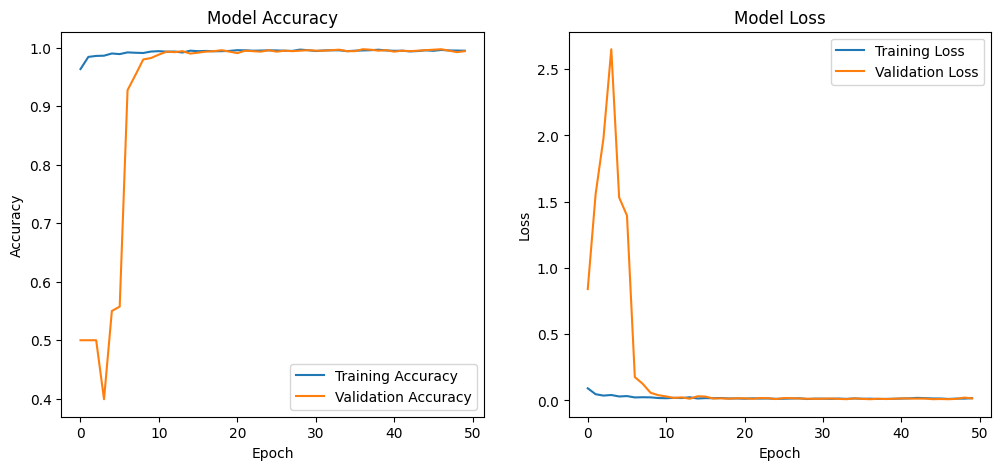

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


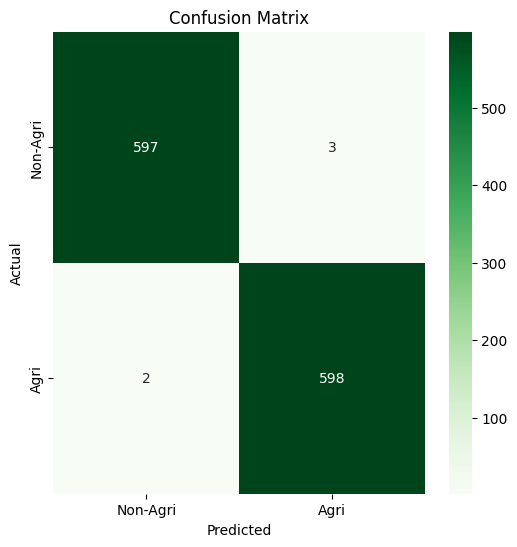

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       600
           1       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [10]:

# -------------------------------
# 1. Plot Accuracy and Loss Curves
# -------------------------------
plt.figure(figsize=(12, 5))

# Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the figure for GitHub / documentation
plt.savefig('training_accuracy_loss.png', dpi=300)
plt.show()

# -------------------------------
# 2. Confusion Matrix
# -------------------------------
Y_pred = model.predict(val_gen)
y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to class labels

cm = confusion_matrix(val_gen.classes, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Agri', 'Agri'], yticklabels=['Non-Agri', 'Agri'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# -------------------------------
# 3. Classification Report
# -------------------------------
print("Classification Report:")
print(classification_report(val_gen.classes, y_pred))


## Part 6: Model Deployment & Saving

### Description
After successful training and evaluation, the finalized model is **saved in the `.keras` format**.  
This step ensures that the trained classifier can be **reused for inference**, integrated into other systems, or deployed in real-world applications for **land-use monitoring**.

### Benefits
- **Reusability:** The model can be loaded later without retraining.  
- **Integration:** Ready for incorporation into larger applications or pipelines.  
- **Documentation:** Saves the model state for reproducibility and future reference.  
- **Deployment:** Facilitates deployment to cloud services, web apps, or desktop applications.

### Example Use Cases
- Automatic classification of satellite images into agricultural vs non-agricultural land.  
- Integration into a monitoring system to track land-use changes over time.  
- Sharing the trained model with collaborators or publishing it on GitHub/Kaggle.


In [11]:
# Save the finalized model in .keras format for future use
model_save_path = "final_agriculture_model.keras"
model.save(model_save_path)

print(f"Model successfully saved to: {model_save_path}")

Model successfully saved to: final_agriculture_model.keras


## Part 7: Testing the Model on New Images

### Description
After training and saving the model, it is essential to verify its performance on **new, unseen images**.  
This step demonstrates how the finalized model can classify a **real-world image** into **Agricultural** or **Non-Agricultural** categories.

### Steps

1. **Load the Saved Model**
   - The `.keras` model saved in the previous phase is loaded using `load_model()`.  
   - This ensures that the same trained weights are used for inference.

2. **Prepare a New Image**
   - Any image can be tested (satellite imagery or drone photos).  
   - The image should be **resized** to match the model input dimensions (64×64 pixels).  
   - Pixel values are normalized to `[0, 1]`.

3. **Make Predictions**
   - The model outputs a probability indicating the likelihood of the image being **Agricultural**.  
   - If the probability is greater than 0.5, the image is classified as **Agricultural**; otherwise, **Non-Agricultural**.  
   - This probability helps in understanding the model’s confidence.

4. **Visualization**
   - The tes


Model loaded successfully.


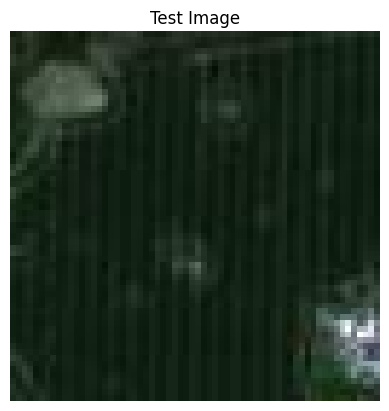

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicted class: Agricultural (0.9999)


In [12]:

# -------------------------------
# 1. Load the saved model
# -------------------------------
model = load_model("final_agriculture_model.keras")
print("Model loaded successfully.")

# -------------------------------
# 2. Load a new image for testing
# -------------------------------
# Replace 'new_image.jpg' with your image path
img_path = "/kaggle/input/test-image/test_image.jpg"
img = Image.open(img_path).resize((64, 64))  # Resize to model input
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# -------------------------------
# 3. Preprocess the image
# -------------------------------
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# -------------------------------
# 4. Make prediction
# -------------------------------
prediction = model.predict(img_array)
pred_class = "Agricultural" if prediction[0][0] > 0.5 else "Non-Agricultural"

print(f"Predicted class: {pred_class} ({prediction[0][0]:.4f})")
